# Circuitos Aritméticos

**Grupo 7:**

- Luís Almeida A84180
- João Pedro Antunes A86813 

 Considere circuitos aritméticos $N * 1$ (N inputs e 1 output), com “wires” de 16 bits  e “gates” de três tipos: 
  1. a “gate” binária $ \oplus $ implementa $\mathtt{xor}$ bit a bit
  
  2. a “gate” binária $+$ implementa soma aritmética ($\mathtt{add}$) de inteiros módulo $2^{16}$,
  
  3. a “gate”  unária $\gg_r $ implementa o “right-shift-rotate” do argumento um número de posições dado pela constante $0<r< 16$.
  
Os parâmetros do circuito são o número de inputs $N$, o número de “gates” $M$ e a razão $\gamma$ entre o número de “gates”  $\mathtt{add}$ e o número total de “gates”.
    
Neste problema 
   1. É dado um circuito aleatoriamente gerado com parâmetros $N,M$ e $\gamma$. 
   2. São dados também  o valor do output final e o “output” de todas as “gates”  $\mathtt{add}$.
    Pretende-se usar Z3 para determinar se os dados são consistentes entre si e, se forem, determinar  inputs que sejam compatíveis com tais outputs.

### Geração dos Circuitos

Podemos modelar os circuitos aritméticos como grafos orientados. O circuito terá $N$ "inputs" e $1$ "output" final, pelo que teremos no mínimo $N+1$ "wires". Os "wires" que são "inputs" têm de ser fixados no início do grafo e o "wire" de "output" final será o "sink" $r$ que, para todas as "sources" $s$, existe um caminho de $s$ para $r$. Temos portanto que fixar o "sink" $r$ no fim do grafo. Os "gates" não serão nada mais do que nodos "intermédios" do grafo que representam a operação a ser realizada sobre a informação que lhes é fornecida. A informação irá fluir sempre dos "inputs" para os "outputs", pelo que podemos olhar para o grafo como uma árvore. A "root" desta árvore será o nodo $0$, estando este ligado a todos os "wires" de "input".
<img src="circuito.png" width=400/>

Para distinguirmos "wires" e "gates", assim como "wires" de "input" e "wires" de output, "gates" add de "gates xor, vamos etiquetar cada nodo com a respetiva "wire" ou "gate" que este representa. Para gerarmos circuitos aleatórios, podemos determinar aleatoriamente o número de cada tipo de "gate" presente no circuito. Posteriormente percorrem-se todas as "gates" ao acaso, escolhendo aleatoriamente os "inputs" de cada gate. Resta apenas garantir que para todas as "sources" $s$ existe um caminho para o nodo do "output" final do circuito, o "sink" $r$. Para este efeito podemos simplesmente descartar os grafos gerados que não têm esta propriedade e gerar um novo grafo até que esta se verifique.

In [2]:
from z3 import *
#from pygraphviz import *
import networkx as nx
import random

In [3]:
def gera_circuito(N,M,gama):
    addGts = int(M*gama)      #Determina-se o número de gates add
    G = nx.DiGraph()
    G.add_node(0, type = "root")   #Etiqueta-se a root
    for i in range(N):
        G.add_node(i+1, type = "Input")  #Criam-se os wires de Input
        G.add_edge(0,i+1)    #Liga-se a root aos inputs

    comp = M - addGts #Nodos restantes sem ser somas

    xorGts = random.randint((N -1 -addGts),comp) #numero de gates xor
    rotGts = comp - xorGts #numero de gates rotate

    #addGts, rotGts, xorGts
    # 1 -> add, 2 -> rotate, 3 -> xor

    aux = [1]*addGts + [2]*rotGts + [3]*xorGts
    random.shuffle(aux) #Percorrem-se as gates do circuito ao acaso 

    for x in aux:
        n = len(G)
        inpts = random.choices(list(range(1,n)),k = 2) #Escolhem-se os inputs da gate x, um nodo qualquer do 
                                                       #grafo exceto a root
        if x == 1:
            G.add_node(n, type = "Sum", inputs = inpts)
            G.add_edge(inpts[0],n)
            G.add_edge(inpts[1],n)
        
        elif x == 2:
            G.add_node(n, type = "Rot", r = random.randint(1,15), inputs = inpts[0]) #O número de bits a rodar
            G.add_edge(inpts[0],n)                                                 # é aleatório

        elif x == 3:
            G.add_node(n, type = "Xor", inputs = inpts)
            G.add_edge(inpts[0],n)
            G.add_edge(inpts[1],n)

    return G

def verificaCircuito(graph, outN):        #Verifica se existe um caminho de todas as sources para o output final
    for x in graph:
        if not nx.has_path(graph,x,outN):
            return False
    return True

def get_circuito(N,M,gama):      #Gera grafos enquanto não gerar algum grafo que represente um circuito
    g = gera_circuito(N,M,gama)
    while not verificaCircuito(g,len(g)-1):
        g = gera_circuito(N,M,gama)
    return g

### Consistência dos dados

Conforme referido no enunciado é agora pedido que, dados um "output" final do circuito e os resultados de cada "gate" add, se determine se estes valores são consistentes entre si, ou seja, se existe algum "input" do circuito cujo "output" é o resultado dado, bem como o resultado de cada "gate" add é o valor dado. Podemos começar por definir uma função que, dado um circuito, um "input" e um número $N$ de "inputs", determine o "output" final do circuito, bem como o valor de cada "gate" add. Comecemos por definir funções que vão implementar a operação de cada "gate" no circuito:

In [4]:
def fromBin(a):
    r = 0
    for i in range(16):
        r = 2*r
        if (a[i]=='1'):
            r = r+1
    return r

def toBin(a):
    r = []
    for _ in range(16):
        r.insert(0,'1' if a%2==1 else '0')
        a = a//2
    return ''.join(r)

def xor_16(b1,b2):
    return b1 ^ b2

def add_16(a,b):
    return (a+b)%(2**16)

def rotate_16(b,r):
    return ((b >> r)%(2**16) | (b << 16-r))

Vamos agora definir uma função que calcula o "output" de um dado circuito quando lhe é fornecido um determinado "input". Esta função tem de apenas percorrer o grafo e executar as operações etiquetadas em cada nodo. Podemos utilizar uma *breadth-first-search* para este efeito e assim encarar o circuito por "níveis". Vamos começar por dividir o "input" do circuito entre os "wires" de "input". Criamos um dicionário $d$ que, para todo o $x \in d$, irá armazenar o resultado da operação especificada pelo nodo $x$. De seguida, iniciamos uma travessia no grafo a partir da root e por cada nodo que visitarmos inspecionamos a sua etiqueta. Executamos a operação determinada pela etiqueta e guardamos o resultado no dicionário. Quando já não houverem nodos por visitar significa que chegamos ao nodo onde está o output final, pelo que apenas precisamos de retornar o seu valor.

In [5]:
def calcula_circuito(graph,inp,N):
    d = {}
    for i in range(N):
        d[i+1] = fromBin(inp[i*16:(i+1)*16])    #Divide-se o input pelos wires de input
    
    queue = [0]
    outsGate = {}   #Dicionário que armazena o valor dos gates add
    while queue:
        x = queue.pop(0)
        for (u,v) in graph.out_edges(x):
            if v not in queue:
                queue.append(v)
                queue.sort()    #Faz-se um sort à orla para podermos encarar o circuito da esq para a dir
        if graph.nodes[x]['type'] == 'Sum':
            d[x] = add_16(d[graph.nodes[x]['inputs'][0]],d[graph.nodes[x]['inputs'][1]]) #Guardar o valor do resul-
            outsGate[x] = d[x]                                              #tado da gate no dicionário d
        
        elif graph.nodes[x]['type'] == 'Xor':
            d[x] = xor_16(d[graph.nodes[x]['inputs'][0]],d[graph.nodes[x]['inputs'][1]])
        
        elif graph.nodes[x]['type'] == 'Rot':
            d[x] = rotate_16(d[graph.nodes[x]['inputs']],graph.nodes[x]['r'])
        
        if not queue:
            return (toBin(d[x]),outsGate) #Retorna-se o output do circuito, bem como um dicionário que nos indica
                                       # qual o valor de cada gate add
    return 0

Temos então de usar o Z3 para determinar se um conjunto de valores para cada gate add e um determinado "output" final são consistentes entre si. Utilizando teoria de *bit vectors* em conjunto com Lógica Proposicional podemos resolver este problema invertendo o circuito. Caso o Solver retorne unsat, sabemos que o conjunto de valores não é consistente entre si, caso contrário apresentar-se-ão alguns inputs que são consistentes com a informação fornecida. Comecemos por definir as operações do circuito usando Z3:

In [6]:
def xor_16z3(b1,b2):
    return b1 ^ b2

def add_16z3(b1,b2):
    return b1+b2    

def rotate_16z3(b,r):
    return ((b << 16-r) | LShR(b,r))

Para invertermos o circuito vamos começar por criar um *bit vector* por cada "wire" de "input". De seguida percorremos o grafo, executando novamente as operações especificadas por cada nodo. No entanto, temos de adicionar a restrição de que, para cada "gate" add, o resultado tem de ser igual ao especificado no input da função. No fim de percorrermos o grafo, apenas forçamos o output a ser igual ao indicado.

In [7]:
def inverte_circuito(graph,out,outGates):
    d = {}
    sol = Solver()
    
    queue = [0]
    
    while queue:
        x = queue.pop(0)
        for (u,v) in graph.out_edges(x):
            if v not in queue:
                queue.append(v)
                queue.sort()
        
        if graph.nodes[x]['type'] == 'Sum':
            d[x] = add_16z3(d[graph.nodes[x]['inputs'][0]],d[graph.nodes[x]['inputs'][1]])
            sol.add(d[x] == outGates[x])
        
        elif graph.nodes[x]['type'] == 'Xor':
            d[x] = xor_16z3(d[graph.nodes[x]['inputs'][0]],d[graph.nodes[x]['inputs'][1]])
        
        elif graph.nodes[x]['type'] == 'Rot':
            d[x] = rotate_16z3(d[graph.nodes[x]['inputs']],graph.nodes[x]['r'])
        
        elif graph.nodes[x]['type'] == 'Input':
            d[x] = BitVec(str(x)+'inpt',16)
        
        if not queue:
            sol.add(fromBin(out) == d[x])
    
    r = sol.check()
    if r == sat:
        print('Consistente')
        l = []
        cnt = 0
        while sol.check() == sat and cnt != 5:
            m = sol.model()
            l.append("".join([toBin(m[d[y]].as_long()) if m[d[y]] != None else "".join(random.choices(["0","1"],k = 16)) for x,y in graph.out_edges(0)]))
            sol.add(Not(And([d[y] == m[d[y]] for x,y in graph.out_edges(0)])))
            cnt += 1
            
        return l
    
    else:
        print('Inconsistente')
    return []

De seguida apresenta-se uma função que apenas imprime o circuito:

In [8]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

In [9]:
def showCircuito(G):
    pos= hierarchy_pos(G)
    lbs = nx.get_node_attributes(G,"type").copy()
    rots = nx.get_node_attributes(G,"r")
    lbs = {k : lbs[k] + " " +str(rots.get(k,"")) for k in lbs}
    nx.draw_networkx(G,pos = pos,labels=lbs, \
                 node_color = "#ffffff", node_size = 600, font_color = "#ff0000")
    pass

### Exemplos

1101010100101000100000000100111010000101110001110101011110001100
('0010010110001000', {6: 21878, 7: 18041, 9: 6436, 11: 9608})


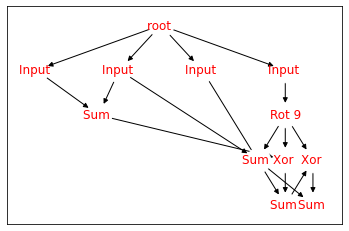

In [13]:
n = 4
M = 7
gama = 4/7

def randInput(N):
    res = random.choices(["0","1"],k = N*16)
    return "".join(res)

k = randInput(n)

G = get_circuito(n,M,gama)
showCircuito(G)
print(k)
r = calcula_circuito(G,k,n)
print(r)

In [14]:
inverte_circuito(G,'0010010110001000', {6: 21878, 7: 18041, 9: 6436, 11: 9608})

Consistente


['1101010100101000100000000100111010000101110001110101011110001100']

In [15]:
inverte_circuito(G,'0010010110001000', {6: 21878, 7: 18041, 9: 6436, 11: 9607})

Inconsistente


[]